In [1]:
import sys
sys.path.append('/mnt/d/ariel2/code/core/')
sys.path.append('d:/ariel2/code/core/')
sys.path.append('/kaggle/input/my-ariel2-library')
import kaggle_support as kgs
import ariel_model
import ariel_numerics
import ariel_gp
import ariel_load
import time
import numpy as np
import multiprocess
import importlib
import copy
import cupy as cp
import matplotlib.pyplot as plt
from tqdm import tqdm

local


In [2]:
train_data=kgs.load_all_train_data()
train_data=train_data[:100]

In [3]:
if False:
    R = 1125*len(train_data)
    C = 32*282

    A_row = np.memmap(kgs.temp_dir + 'AIRS_row.memmap',  dtype=np.float32, mode='w+', shape=(R, C), order='C')
    A_col = np.memmap(kgs.temp_dir + 'AIRS_col.memmap',  dtype=np.float32, mode='w+', shape=(R, C), order='F')

    R = 1105*len(train_data)
    C = 32*282

    R_row = np.memmap(kgs.temp_dir + 'AIRS_res_row.memmap',  dtype=np.float32, mode='w+', shape=(R, C), order='C')
    R_col = np.memmap(kgs.temp_dir + 'AIRS_res_col.memmap',  dtype=np.float32, mode='w+', shape=(R, C), order='F')


    loaders = ariel_load.default_loaders()
    for ii in range(2):
        loaders[ii].apply_pixel_corrections.mask_hot= False
    for ii,d in tqdm(enumerate(train_data)):
        d = copy.deepcopy(d)

        d.load_to_step(3, loaders)    
        data = d.transits[0].data[1].data

        A_row[1125*ii:1125*(ii+1),:] = data.reshape(1125,32*282).get()
        A_col[1125*ii:1125*(ii+1),:] = data.reshape(1125,32*282).get()

        residuals = ariel_numerics.remove_trend_cp(data)[10:-10,...]

        ariel_load.inpaint_vectorized(data)
        assert not cp.any(cp.isnan(data))

        x=cp.mean(data,(0,1))
        if d.planet_id == train_data[0].planet_id:
            base_scaling = x
            kgs.dill_save(kgs.calibration_dir + 'AIRS_base_scaling.pickle', base_scaling.get())
        residuals = residuals/x*base_scaling

        R_row[1105*ii:1105*(ii+1),:] = residuals.reshape(1105,32*282).get()
        R_col[1105*ii:1105*(ii+1),:] = residuals.reshape(1105,32*282).get()

        d.load_to_step(0, ariel_load.default_loaders())



        if ii%20==0:
            A_row.flush()
            A_col.flush()
            R_row.flush()
            R_col.flush()

    A_row.flush()
    A_col.flush()
    R_row.flush()
    R_col.flush()
    kgs.clear_gpu()
base_scaling = cp.array(kgs.dill_load(kgs.calibration_dir + 'AIRS_base_scaling.pickle'))

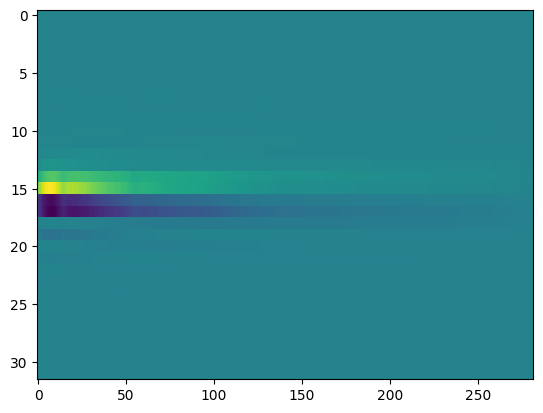

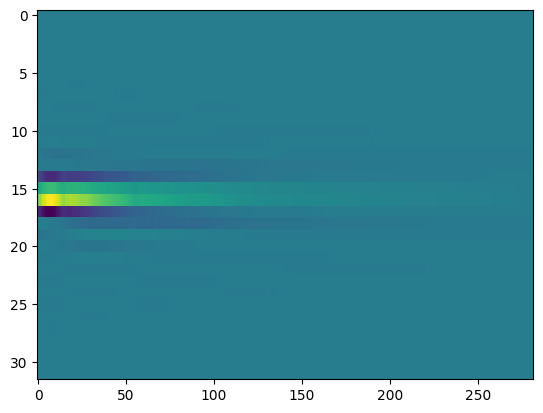

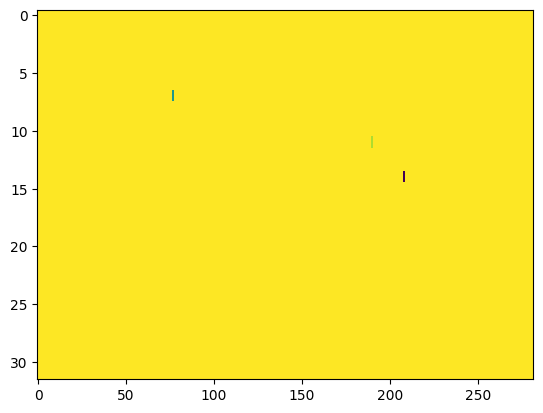

In [4]:
if False:
    R_row = np.memmap(kgs.temp_dir + 'AIRS_res_row.memmap',  dtype=np.float32, mode='r', shape=(1105*len(train_data), 32*282), order='C')#[:50000,...]
    R_col = np.memmap(kgs.temp_dir + 'AIRS_res_col.memmap',  dtype=np.float32, mode='r', shape=(1105*len(train_data), 32*282), order='F')#[:50000,...]
    import mmap
    R_row._mmap.madvise(mmap.MADV_SEQUENTIAL)
    R_col._mmap.madvise(mmap.MADV_SEQUENTIAL)
    importlib.reload(ariel_numerics)
    kgs.profiling = False
    W_combined = np.zeros((R_row.shape[0],0))
    C_combined = np.zeros((0,R_row.shape[1]))
    for ii in range(3):
        W,C,S=ariel_numerics.nan_pca_rank1_memmap(R_row, R_col, W_combined, C_combined, row_batch = 4096, col_batch = 32, verbose=True, acc_dtype=np.float32, max_iter=10)
        W_combined = np.concatenate((W_combined, W[:,None]),1)
        C_combined = np.concatenate((C_combined, C),0)
        
        
    kgs.dill_save(kgs.calibration_dir + 'AIRS_jitter.pickle', (C_combined, W_combined))

C_combined, W_combined = kgs.dill_load(kgs.calibration_dir + 'AIRS_jitter.pickle')
for ii in range(3):
    #plt.figure(figsize=(20,20))
    plt.figure()
    plt.imshow(C_combined[ii,:].reshape(32,282), aspect='auto', interpolation='none')

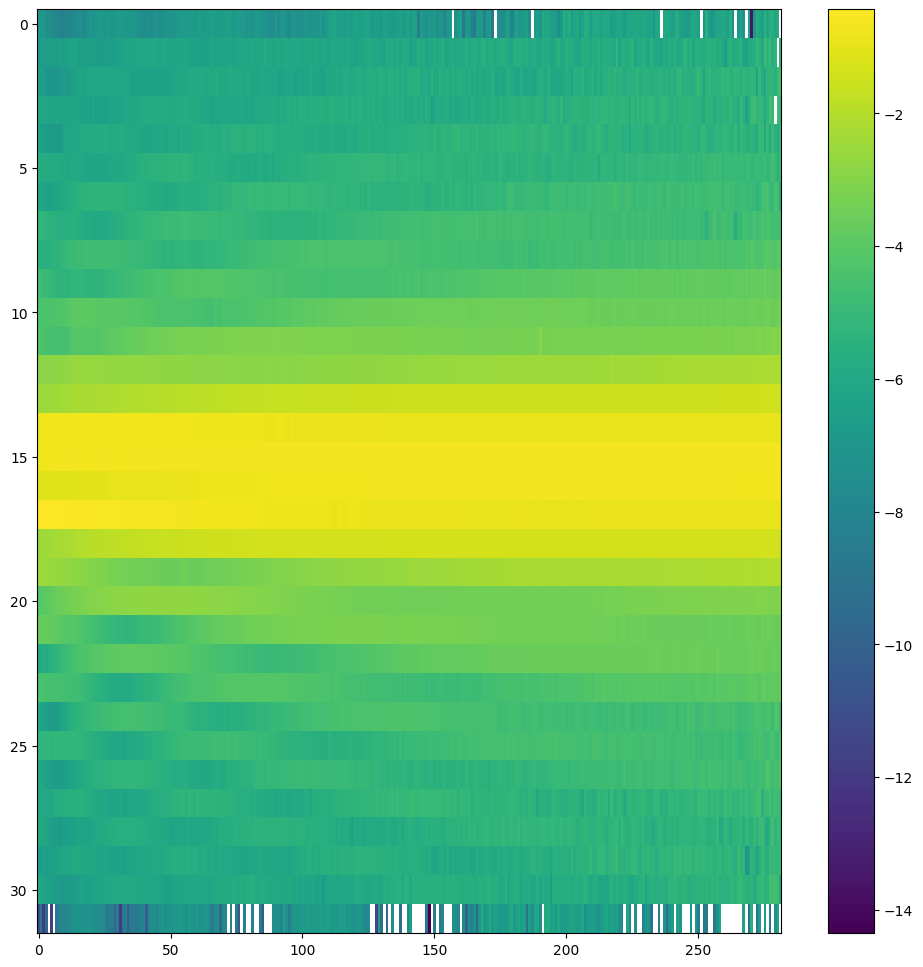

In [5]:
if False:
    def correct_AIRS_jitter(data):

        data_inpaint = copy.deepcopy(data)

        # Rescale
        ariel_load.inpaint_vectorized(data_inpaint)
        if kgs.debugging_mode>=1:
            assert not cp.any(cp.isnan(data_inpaint))
        x=cp.mean(data,(0,1))
        data[...] = data/x*base_scaling
        orig_shape = data.shape   
        data = data.reshape(-1,orig_shape[1]*orig_shape[2])

        design_matrix = cp.array(C_combined)[:2,:]
        coeffs = ariel_numerics.lstsq_nanrows_normal_eq_with_pinv_sigma(data.T, design_matrix.T, return_A_pinv_w=False)[0]
        data -= (design_matrix.T@coeffs).T

        # Unscale
        data = data.reshape(orig_shape)
        data[...] = data*x/base_scaling

        return data


    R_row = np.memmap(kgs.temp_dir + 'AIRS_row.memmap',  dtype=np.float32, mode='r', shape=(1125*len(train_data), 32*282), order='C')#[:50000,...]

    data = []
    for ii in tqdm(range(len(train_data))):
        this_data = cp.array(np.mean(R_row[1125*ii:1125*(ii+1),...],0), dtype=cp.float64).reshape(1,32,282)
        this_data = correct_AIRS_jitter(this_data)
        data.append(this_data)
    data = cp.concatenate(data)
    #data = data-cp.mean(data,0)
    data.shape
    C0_combined = cp.zeros( (32,282) )
    for i_wavelength in tqdm(range(282)):
        this_data = data[:,:,i_wavelength]    
        C0_combined[:,i_wavelength]=ariel_numerics.nan_pca(this_data,1)[1][0,:]
        C0_combined[:,i_wavelength] = C0_combined[:,i_wavelength]*np.sign(C0_combined[15,i_wavelength])
        
    kgs.dill_save(kgs.calibration_dir + 'AIRS_C0.pickle', (C0_combined))
    
C0_combined = kgs.dill_load(kgs.calibration_dir + 'AIRS_C0.pickle')
plt.figure(figsize=(12,12))
plt.imshow(cp.log(C0_combined).get(), aspect='auto', interpolation='none')
plt.colorbar()

In [6]:
print(C_combined.shape)

(3, 9024)


  0%|                                                                                            | 0/10 [00:00<?, ?it/s]

35 4181.483041871778 22 False
40 980.2628320178428 21 False
54 9171.670544408853 15 False
71 2028.1365483537743 9 False
76 640.3069422516171 22 False
119 1913.1919949986948 20 False
126 1159.0738491669376 22 False
138 2431.0672761702044 21 False
141 330.61064028125384 4 False
149 326.4250638082048 2 False
157 1432.1812106065372 21 False
167 333.1390482756233 23 False
168 345.2093379799942 23 False
204 407.5538325550655 8 False
208 4001.0755921277405 14 False
222 1379.0696823571725 20 False
245 593.516087025265 9 False
263 599.3624764724368 11 False
269 438.5307748541449 9 False


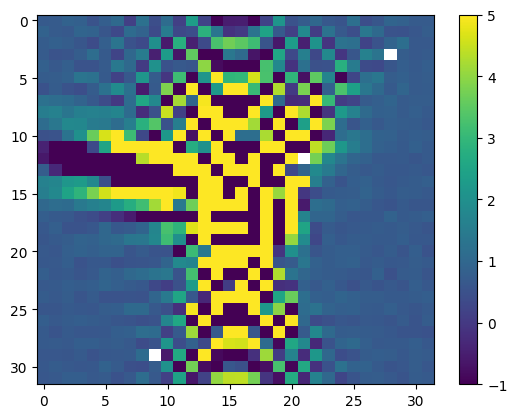

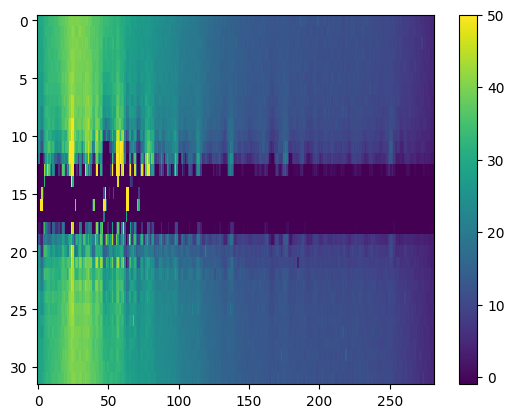

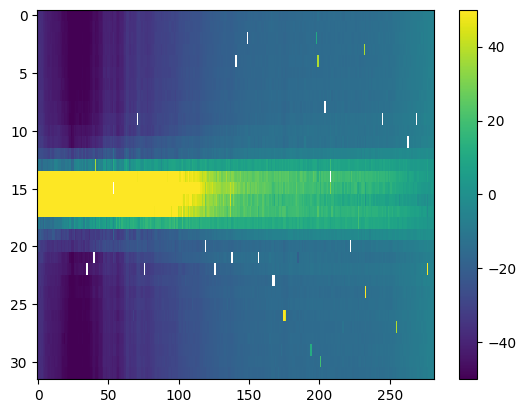

 10%|████████▍                                                                           | 1/10 [00:06<01:00,  6.69s/it]

35 2554.013421333597 22 False
40 643.5775026649751 21 False
54 6738.193096980482 15 False
71 1297.0112401133183 9 False
76 427.7202191799668 22 False
119 1266.1970161996046 20 False
126 708.1788395731069 22 False
138 1488.9757908746717 21 False
157 977.653662322231 21 False
208 2818.1271852948753 14 False
222 896.4457901140605 20 False
245 352.1657160084612 9 False
263 369.9154016106235 11 False


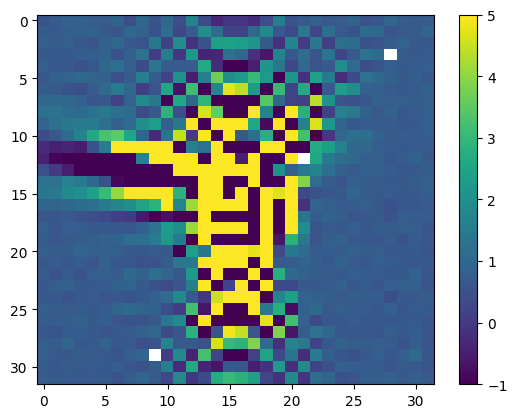

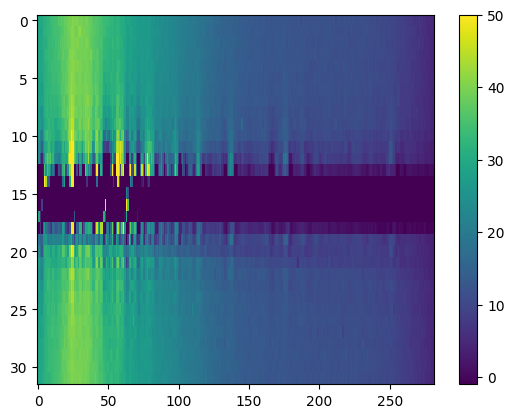

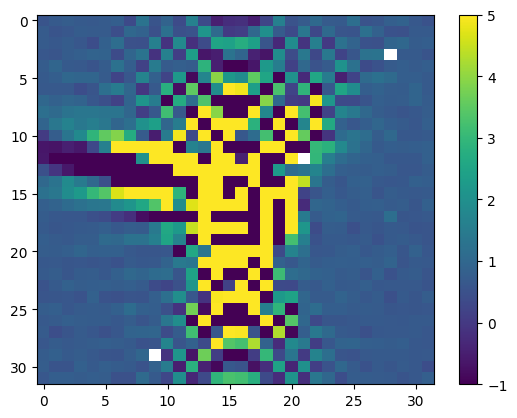

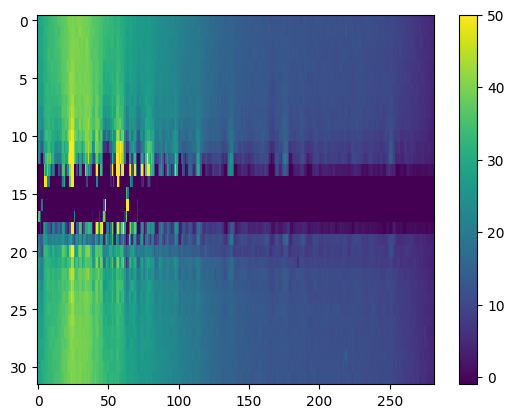

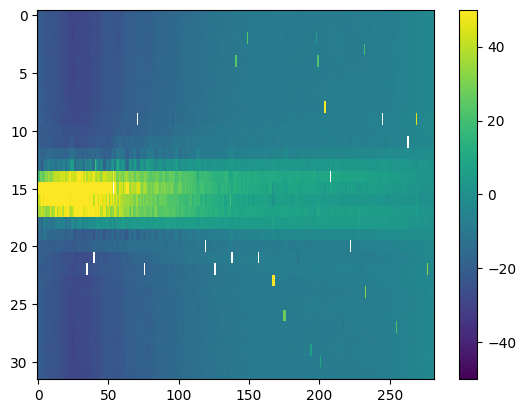

 20%|████████████████▊                                                                   | 2/10 [00:15<01:01,  7.66s/it]

35 3832.5307511566098 22 False
40 940.7601996379107 21 False
54 8533.797129308175 15 False
71 1939.8528792510704 9 False
76 621.8977114458127 22 False
119 1906.1342158315879 20 False
126 1174.2413075386216 22 False
138 2466.1316386695057 21 False
141 321.05241550040427 4 False
149 308.4758609790857 2 False
157 1444.1788399329153 21 False
167 331.8176320430713 23 False
168 334.3730991296021 23 False
204 398.8154544439127 8 False
208 3894.1740423093565 14 False
222 1314.9872446312258 20 False
245 573.3632262405664 9 False
263 579.1205260407256 11 False
269 444.6679630380544 9 False


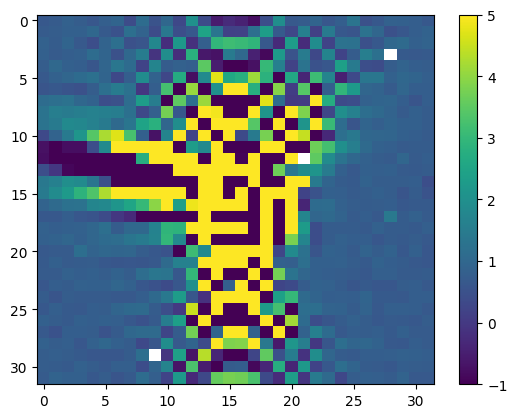

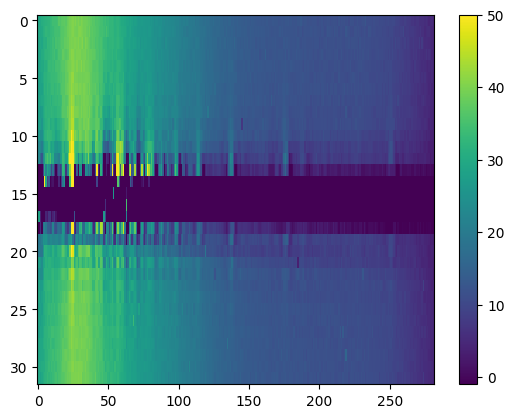

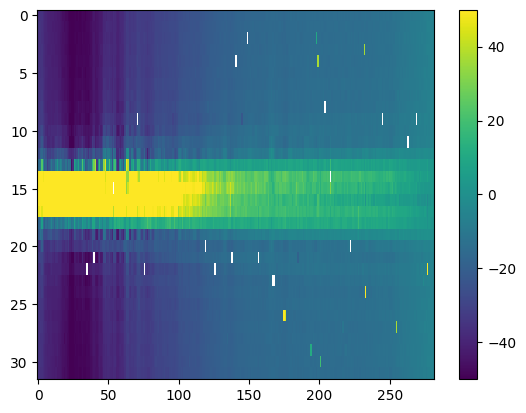

 30%|█████████████████████████▏                                                          | 3/10 [00:22<00:52,  7.44s/it]

35 3164.4801279888857 22 False
40 716.0449890097588 21 False
54 7386.829528066927 15 False
71 1511.4920851167087 9 False
76 498.89488765063066 22 False
119 1552.3333996877354 20 False
126 855.2935850038486 22 False
138 1846.835423489376 21 False
157 1126.6427169586952 21 False
208 3195.3731375251414 14 False
222 1037.8428452488606 20 False
245 433.6708628299215 9 False
263 437.5757065087968 11 False
269 315.04644670695154 9 False


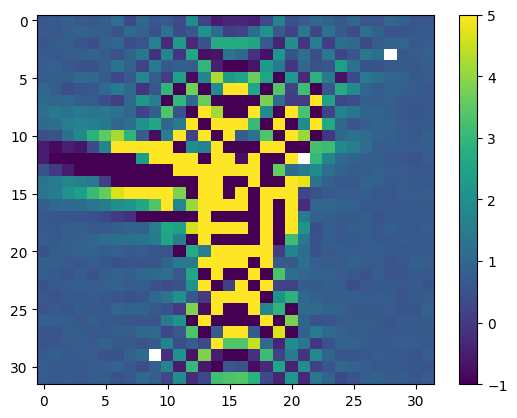

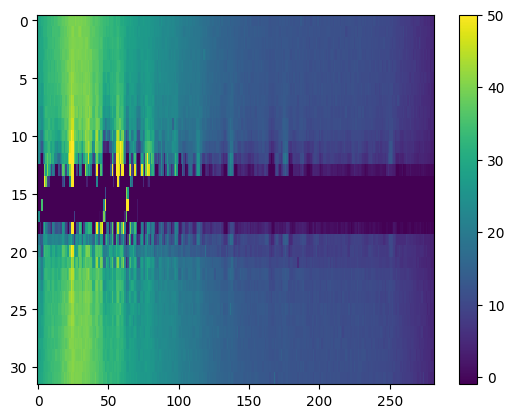

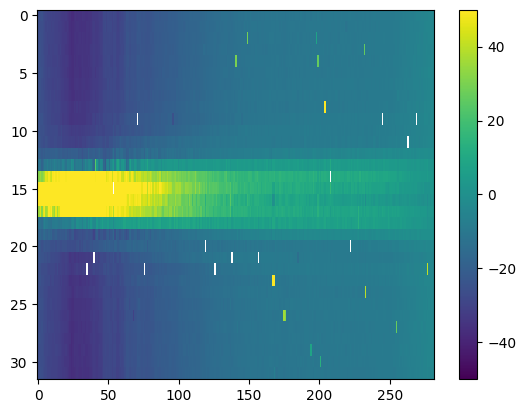

 40%|█████████████████████████████████▌                                                  | 4/10 [00:29<00:44,  7.43s/it]

35 2149.8343337554475 22 False
40 521.6888368742235 21 False
54 5847.995406113477 15 False
71 1105.2872503552019 9 False
76 708.4863131548628 22 False
119 994.4519457055559 20 False
126 592.3552062010506 22 False
138 1206.6308573765866 21 False
157 1390.7679980324392 21 False
167 300.3305123941015 23 False
168 329.07388616847885 23 False
204 334.3483468934976 8 False
208 3913.788879652015 14 False
222 702.6852366404547 20 False
245 518.5947011650293 9 False
263 634.0582857547192 11 False


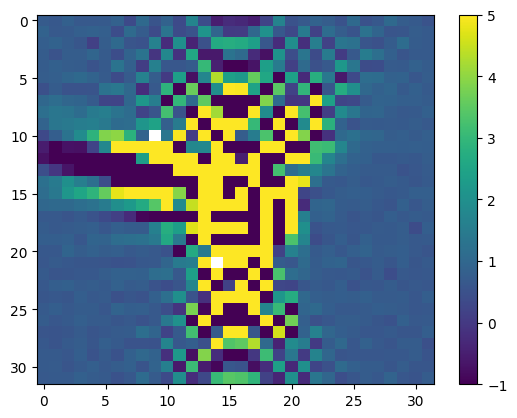

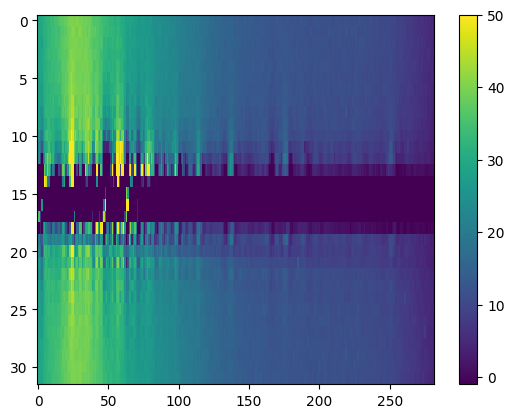

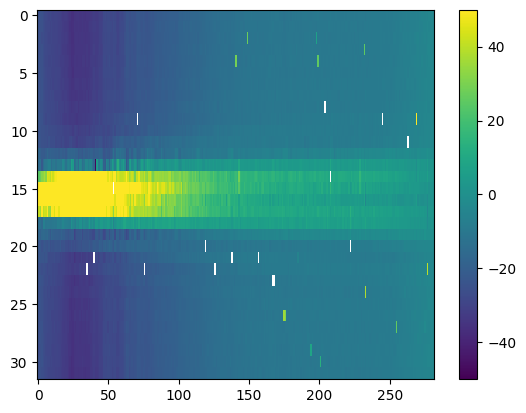

 50%|██████████████████████████████████████████                                          | 5/10 [00:36<00:36,  7.25s/it]

35 3438.06636446563 22 False
40 834.5661371833631 21 False
54 7810.089636171024 15 False
71 1733.9725574756583 9 False
76 548.0822878328427 22 False
119 1662.0079383790955 20 False
126 969.2563033630277 22 False
138 2061.9847909893083 21 False
157 1251.6203614059475 21 False
204 327.19492664075676 8 False
208 3580.806264474035 14 False
222 1137.471094253212 20 False
245 489.2364186228163 9 False
263 495.1972461931029 11 False
269 361.18624145303136 9 False


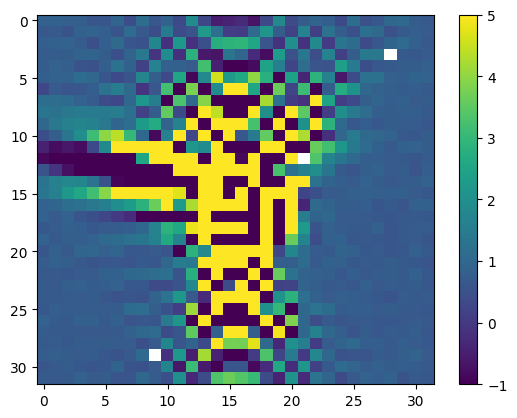

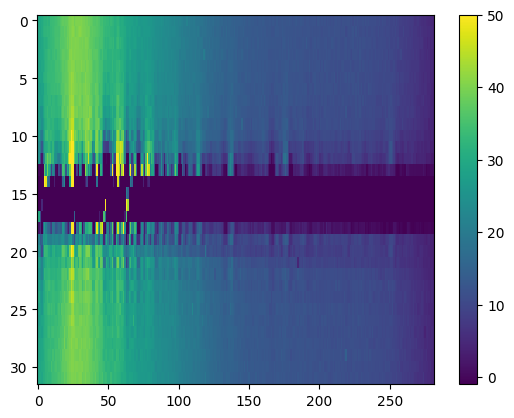

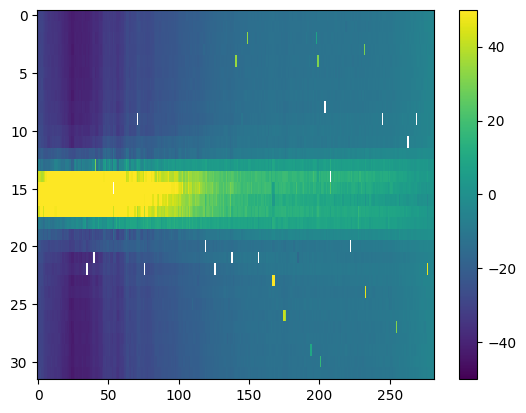

 60%|██████████████████████████████████████████████████▍                                 | 6/10 [00:43<00:28,  7.12s/it]

35 2401.0749189042335 22 False
40 603.2855339122536 21 False
54 6468.626468811085 15 False
71 1199.0717554632706 9 False
76 376.9484942865551 22 False
119 1213.8598452454255 20 False
126 669.2972541291783 22 False
138 1477.9606112354681 21 False
157 907.15407321927 21 False
208 2814.305976622165 14 False
222 832.2167341255457 20 False
245 332.7020518624741 9 False
263 346.2340678082852 11 False


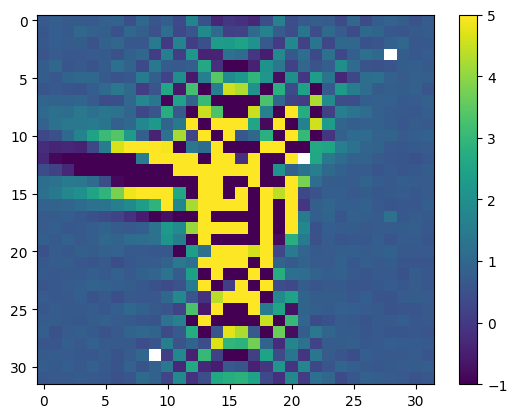

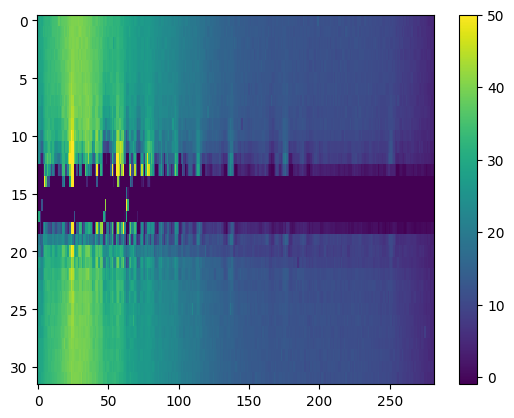

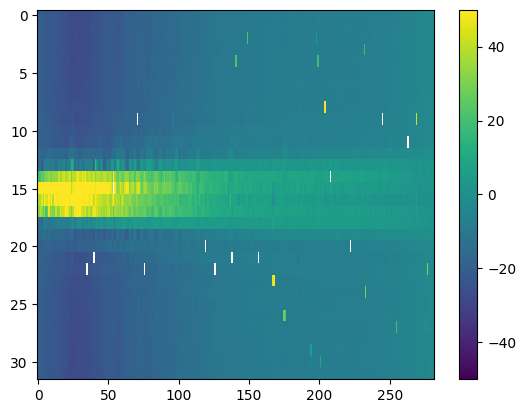

 70%|██████████████████████████████████████████████████████████▊                         | 7/10 [00:48<00:19,  6.57s/it]

35 2596.562135712156 22 False
40 653.5049456238714 21 False
54 6743.077944239761 15 False
71 1351.3770255560948 9 False
76 418.1922964937522 22 False
119 1364.612106921302 20 False
126 743.7072554363574 22 False
138 1513.68604010357 21 False
157 952.413630079399 21 False
208 2789.33722058163 14 False
222 897.1525123890547 20 False
245 347.7343836362348 9 False
263 367.66923472730286 11 False


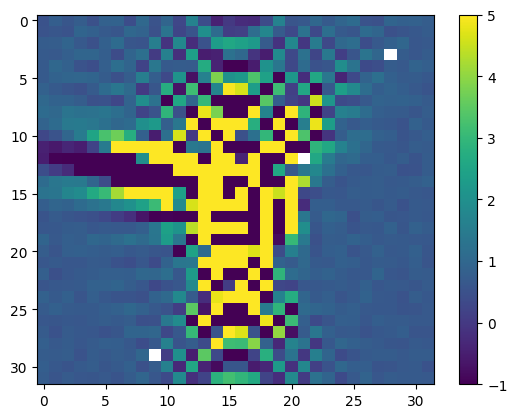

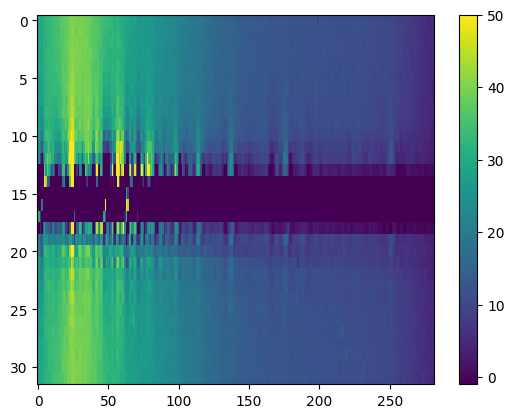

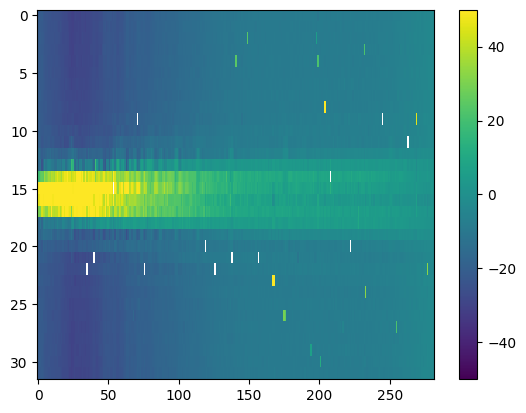

 80%|███████████████████████████████████████████████████████████████████▏                | 8/10 [00:54<00:12,  6.41s/it]

35 2482.446156539584 22 False
40 591.1218053191991 21 False
54 6507.622861438306 15 False
71 1295.0397426961288 9 False
76 851.570839953894 22 False
119 1192.6024578922256 20 False
126 694.1990732237699 22 False
138 1364.85611223226 21 False
157 1607.0358697598003 21 False
167 397.1542606171924 23 False
168 404.617009978063 23 False


In [ ]:
def get_coeffs(data):
    
   # data_inpaint = copy.deepcopy(data)

    # Rescale
    #ariel_load.inpaint_vectorized(data_inpaint)
    #if kgs.debugging_mode>=1:
    #    assert not cp.any(cp.isnan(data_inpaint))
    #x=cp.mean(data_inpaint,1)
    #data[...] = data/x[:,None,:]*base_scaling
    #orig_shape = data.shape   
    #data = data.reshape(-1,orig_shape[1]*orig_shape[2])
    
#    noise_est = ariel_numerics.estimate_noise_cp(data)
    
#     plt.figure()
#     plt.imshow(cp.mean(data,0).reshape(32,282).get(), interpolation='none', aspect='auto')
    
#     plt.figure()
#     plt.imshow(ariel_numerics.estimate_noise_cov_cp(data.reshape(1125,32,282)[:,:,0]).get())
#     plt.colorbar()
        

#         plt.figure()
#         plt.plot(noise_est.get())

#         design_matrix = cp.zeros((3*282,32*282))
#         #design_matrix[:2,:] = cp.array(C_combined[:2,:])
#         for i_wavelength in range(282):
#             #design_matrix[i_wavelength+2,32*i_wavelength:32*(i_wavelength+1)] = C0_combined[:,i_wavelength]
#             design_matrix[3*i_wavelength,i_wavelength::282] = C0_combined[:,i_wavelength]
#             design_matrix[3*i_wavelength+1:3*i_wavelength+2,i_wavelength::282] = C_combined[:2,:]
            
# #         plt.figure()
# #         plt.plot(cp.log(cp.sum(design_matrix,0)).get())
        
# #         plt.figure()
# #         plt.plot(cp.log(cp.sum(design_matrix,1)).get())
        
#         assert not cp.any(cp.isnan(design_matrix))
 
#         #noise_est = cp.sqrt(cp.abs(C0_combined)).flatten()
#         for ii in range(8):
#             noise_est[282*ii:282*(ii+1)]*=10000
#             #noise_est[31-ii::32]*=100
#         for ii in range(24,32):
#             noise_est[282*ii:282*(ii+1)]*=10000
#         res = ariel_numerics.lstsq_nanrows_normal_eq_with_pinv_sigma(data.T, design_matrix.T, return_A_pinv_w=True, sigma=noise_est)  
#         coeffs = res[0]
        
#         A_pinv_w = res[1]
#         A_pinv_w_full = cp.zeros((284,9024))
#         A_pinv_w_full[:,~cp.isnan(data[0,:])] = A_pinv_w
#         # plt.figure()
#         # plt.plot(A_pinv_w_full[2,::282].get())
#         #plt.plot(design_matrix[2,::282].get())
#         #plt.plot((noise_est[::282]/kgs.rms(noise_est[::282])).get())
        
#         xx = noise_est[::282]/cp.sqrt(design_matrix[2,::282])
#         #plt.semilogy((xx/kgs.rms(xx)).get())
#         #print(A_pinv_w.shape, data.shape, design_matrix.shape)
#         # sens = cp.zeros((32,282))
#         # for i_wavelength in range(282):
#         #     sens[:,i_wavelength] = A_pinv_w[:]
#         #plt.figure()
#         #plt.imshow(cp.mean(residual,0).reshape(32,282).get(), aspect='auto', interpolation='none')
#         #plt.colorbar()
    
#         assert not cp.any(cp.isnan(coeffs))

#         residual = (data.T - design_matrix.T@coeffs).T
        
#         # plt.figure()
#         # plt.imshow(cp.mean(residual,0).reshape(32,282).get(), aspect='auto', interpolation='none')
#         # plt.colorbar()
        
#         noise_est = ariel_numerics.estimate_noise_cp(residual)
        
#         # plt.figure()
#         # plt.imshow(ariel_numerics.estimate_noise_cov_cp(residual.reshape(1125,32,282)[:,:,0]).get())
#         # plt.colorbar()
        
#         plt.figure()
#         plt.plot(cp.std(coeffs[2:,:],1).get())
        
       # plt.figure()
       # plt.plot(cp.mean(coeffs[2:,:],1).get())

    coeffs_wl = []
#     noise_est = cp.sqrt(cp.abs(C0_combined))#ariel_numerics.estimate_noise_cp(data.reshape(-1,32*282)).reshape(32,282)
#     noise_est[noise_est<0.1]=0.1

#     plt.figure()
#     plt.imshow(ariel_numerics.estimate_noise_cov_cp(data[:,:,0]).get())
#     plt.colorbar()
    
#     x =cp.array(C_combined[:2,:].reshape(2,32,282)[0:1,:,0])
#     plt.figure()
#     plt.imshow((x.T@x).get())
#     plt.colorbar()
    
#     x =cp.array(C_combined[:2,:].reshape(2,32,282)[1:2,:,0])
#     plt.figure()
#     plt.imshow((x.T@x).get())
#     plt.colorbar()
    
#     rhs = ariel_numerics.estimate_noise_cov_cp(data[:,:,0]).flatten()
    
    # plt.figure()
    # plt.imshow(ariel_numerics.estimate_noise_cov_cp(data[:,:,0]).get())
    # plt.colorbar()
    
    #data = 0*data+50
    
    #data+=50
    
    residualf = copy.deepcopy(data)
    
    noise_output = cp.zeros(282)
    noise_seen = cp.zeros(282)
    noise_no_jitter = cp.zeros(282)
    
    noise_data_combined = cp.zeros((32,282))
    residual_expected = cp.zeros((32,282))
    
   # wt1 = cp.zeros((1125,282))

    for i_wavelength in range(282):
        
        isnan = cp.isnan(data[0,:,i_wavelength])
        
        rhs = ariel_numerics.estimate_noise_cov_cp(data[:,:,i_wavelength])
        
        rhs[isnan,:] = 0
        rhs[:,isnan] = 0
        
        rhs=rhs.flatten()
        
       # plt.figure()
       # plt.imshow(rhs.reshape(32,32).get())
        
        x = cp.array(C_combined[:2,:].reshape(2,32,282)[0:1,:,i_wavelength])
        #rint(x.shape, isnan.shape)
        x[:,isnan]=0
        x1 = (x.T@x).flatten()
        
        
        
        
        
        x = cp.array(C_combined[:2,:].reshape(2,32,282)[1:2,:,i_wavelength])
        x[:,isnan]=0
        x2 = (x.T@x).flatten()
        
        x = C0_combined[:,i_wavelength]
        x[isnan]=0
        x3 = (x.T@x).flatten()
        
        design_matrix = cp.zeros((32*32, 3+32))
        design_matrix[:,0] = x1
        design_matrix[:,1] = x2
        design_matrix[:,2] = x3
        for ii in range(32):
            design_matrix[33*ii,ii+3]=1
            
#         plt.figure()
#         plt.imshow(design_matrix[:,0].reshape(32,32).get())
        
#         plt.figure()
#         plt.imshow(design_matrix[:,17].reshape(32,32).get())


        coeffs = cp.linalg.lstsq(design_matrix, rhs, rcond=None)[0]
    
        residual = rhs - design_matrix@coeffs
        
        noise_est = cp.sqrt(coeffs[3:])
        
        noise_data_combined[:,i_wavelength] = noise_est
        
        # if i_wavelength==0:
        #     plt.figure()
        #     plt.plot((noise_est/cp.sqrt(C0_combined[:,i_wavelength])).get())
        #     plt.figure()
        #     plt.imshow(rhs.reshape(32,32).get())
        #     plt.colorbar()
        #     plt.figure()
        #     plt.imshow(residual.reshape(32,32).get())
        #     plt.colorbar()
            
        

        mean_handled = False
        while True:

            if mean_handled:
                design_matrix = cp.zeros((3,32))
                design_matrix[0,:] = C0_combined[:,i_wavelength]
                design_matrix[1:3,:] = cp.array(C_combined[:2,:].reshape(2,32,282)[:,:,i_wavelength])
                #design_matrix[3,:] = 1
            else:
                design_matrix = cp.zeros((4,32))
                design_matrix[0,:] = C0_combined[:,i_wavelength]
                design_matrix[1:3,:] = cp.array(C_combined[:2,:].reshape(2,32,282)[:,:,i_wavelength])
                design_matrix[3,:] = 1               
            
            N = design_matrix.shape[0]

            #noise_est[:,i_wavelength] = cp.sqrt(cp.abs(design_matrix[0,:]))
            #noise_est[:8,i_wavelength] *= 100000
            #noise_est[24:,i_wavelength] *= 100000
            #if ii==0:
            res = ariel_numerics.lstsq_nanrows_normal_eq_with_pinv_sigma(data[:,:,i_wavelength].T, design_matrix.T, return_A_pinv_w=True, sigma=noise_est)
            #else:
            #    res = ariel_numerics.lstsq_nanrows_normal_eq_with_pinv_sigma(data[:,:,i_wavelength].T, design_matrix.T, return_A_pinv_w=True, sigma=noise_est[:,i_wavelength])
            coeffs = res[0]
            
            #if i_wavelength==0:
            #     plt.figure()
            #     plt.plot(res[1].get().T[:,0])
            
          #  mapping = design_matrix.T@res[1]
            #K_diff = design_matrix
            
            # if i_wavelength==0 and ii==0:
            #     plt.figure()
            #     plt.imshow(np.eye(32)- (mapping.T@mapping).get())
            #     plt.colorbar()
                


            residualf[:,:,i_wavelength] = (data[:,:,i_wavelength].T - design_matrix.T@coeffs).T           #
            
            #print(res[1].shape, cp.diag(noise_est**2).shape)
            A_pinv_w = res[1]
            A_pinv_w_full = cp.zeros((N,32))
            A_pinv_w_full[:,~cp.isnan(data[0,:,i_wavelength])] = A_pinv_w
            noise_est[cp.isnan(data[0,:,i_wavelength])] = 0
            noise_output[i_wavelength] = cp.sqrt((A_pinv_w_full@cp.diag(noise_est**2)@A_pinv_w_full.T)[0,0])
            
            noise_seen[i_wavelength] = ariel_numerics.estimate_noise_cp(coeffs[0,:])
            
#             res2 = ariel_numerics.lstsq_nanrows_normal_eq_with_pinv_sigma(data[:,:,i_wavelength].T, design_matrix[0:3,:].T, return_A_pinv_w=True, sigma=noise_est)
            
#             A_pinv_w = res2[1]
#             A_pinv_w_full = cp.zeros((3,32))
#             A_pinv_w_full[:,~cp.isnan(data[0,:,i_wavelength])] = A_pinv_w
#             noise_est[cp.isnan(data[0,:,i_wavelength])] = 0
#             noise_no_jitter[i_wavelength] = cp.sqrt((A_pinv_w_full@cp.diag(noise_est**2)@A_pinv_w_full.T)[0,0])
            
            mat = design_matrix.T@A_pinv_w_full
            #print(mat.shape)
            cov_expected = cp.diag(noise_est**2) - mat@cp.diag(noise_est**2)@mat.T
            residual_expected[:,i_wavelength] = cp.sqrt(cp.diag(cov_expected))
            
            residual_expected_ratio = cp.mean(residualf[:,:,i_wavelength],0)/residual_expected[:,i_wavelength]*np.sqrt(1125)
            residual_expected_ratio[cp.isnan(residual_expected_ratio)] = 0
            
            #if i_wavelength>200 and i_wavelength<220:
            #    print(i_wavelength, residual_expected_ratio, cp.max(cp.abs(residual_expected_ratio)))
            # if cp.max(cp.abs(residual_expected_ratio))==0:
            #     plt.figure()
            #     plt.imshow(cov_expected.get())
            #     plt.figure()
            #     #plt.plot(residual_expected[:,i_wavelength].get())
            #     plt.plot(cp.std(residualf[:,:,i_wavelength].get()))
            #     print(cp.std(residualf[:,:,i_wavelength].get()))
            #     raise 'stop'
            if cp.any(cp.abs(residual_expected_ratio)>300):
                print(i_wavelength, cp.max(cp.abs(residual_expected_ratio)), cp.argmax(cp.abs(residual_expected_ratio)), mean_handled)
                data[:,cp.argmax(cp.abs(residual_expected_ratio)),i_wavelength] = cp.nan
            else:
                #mean_handled = True
                if not mean_handled:
                    #print(coeffs[3,:].shape)
                    #data[:,:,i_wavelength]-=np.mean(coeffs[3,:])
                    mean_handled = True
                else:
                    coeffs_wl.append(coeffs)
                    break
            # if i_wavelength==0:
            #     plt.figure()
            #     plt.imshow(cp.diag(noise_est**2).get())
            #     plt.colorbar()
            #     plt.figure()
            #     plt.imshow(cov_expected.get())
            #     plt.colorbar()

            #noise_est[:,i_wavelength] = ariel_numerics.estimate_noise_cp(residual)
            
            #H = design_matrix.T@(design_matrix@design_matrix.T)@design_matrix
            
            #if i_wavelength==281:
            #    plt.figure()
            #    plt.plot(noise_est[:,i_wavelength].get())
#             noise_est[:,i_wavelength] /= cp.sqrt(1-cp.diag(H))
#             #if i_wavelength==281:
#             #    plt.plot((noise_est[8:24,i_wavelength]/cp.sqrt(design_matrix[0,8:24])).get())
                
#             noise_est[:,i_wavelength] = cp.sqrt(cp.abs(design_matrix[0,:]))
            
#             noise_est[:8,i_wavelength]*=100000
#             noise_est[24:,i_wavelength]*=100000

            # if i_wavelength==0 and ii==0:
            #     plt.figure()
            #     plt.imshow(ariel_numerics.estimate_noise_cov_cp(residual).get())
            #     plt.colorbar()

        
            #coeffs_wl[-1] = coeffs_wl[-1] / base_scaling[i_wavelength] * x[:,i_wavelength]

    coeffs_wl = [c.T.get() for c in coeffs_wl]
    
    # #print(cp.mean(residualf[:,:,i_wavelength],0)/residual_expected[:,i_wavelength])
    # plt.figure()
    # plt.imshow((cp.mean(residualf,0)/residual_expected*np.sqrt(1125))[:,:].get(), interpolation='none', aspect='auto')
    # #plt.clim([-2,2])
    # plt.colorbar()
    
    plt.figure()
    plt.imshow((cp.mean(residualf,0))[:,:].get(), interpolation='none', aspect='auto')
    plt.clim([-50,50])
    plt.colorbar()
    
#     plt.figure()
#     plt.imshow(cp.std(residualf,0)[:,:].get(), interpolation='none', aspect='auto')
#     plt.clim([0,100])
#     plt.colorbar()
    
#     plt.figure()
#     plt.imshow(residual_expected.get(), interpolation='none', aspect='auto')
#     plt.clim([0,100])
#     plt.colorbar()
    
   # plt.figure()
   # plt.plot([cp.mean(c[:,3])for c in coeffs_wl])
    
#     plt.figure()
#     plt.imshow(noise_data_combined.get(), interpolation='none', aspect='auto')
#     plt.clim([0,100])
#     plt.colorbar()
    
    # plt.figure()
    # plt.imshow(ariel_numerics.estimate_noise_cp(data.reshape(1125,-1)).reshape(32,282).get(), interpolation='none', aspect='auto')
    # plt.colorbar()
    
#     plt.figure()
#     plt.plot(noise_output.get())
#     plt.plot(noise_seen.get())
    #plt.plot(noise_no_jitter.get())
    

    return coeffs_wl

train_data = train_data[:10]
R_row = np.memmap(kgs.temp_dir + 'AIRS_row.memmap',  dtype=np.float32, mode='r', shape=(1125*len(train_data), 32*282), order='C')#[:50000,...]
all_coeffs =[]
importlib.reload(ariel_load)
for ii in tqdm(range(len(train_data))):
    d = copy.deepcopy(train_data[ii])
    loaders = ariel_load.default_loaders()
    #loaders[0].cache_steps = []
    for iii in range(2):
        loaders[iii].apply_pixel_corrections.mask_hot=False
    #loaders[1].apply_full_sensor_corrections.inpainting_2d = False
    loaders[1].apply_full_sensor_corrections.remove_background_based_on_rows = True
    loaders[1].apply_full_sensor_corrections.remove_background_remove_used_rows = False
    d.load_to_step(4,loaders)
    data = d.transits[0].data[1].data
    #data = cp.array(R_row[1125*ii:1125*(ii+1),...], dtype=cp.float64).reshape(1125,32,282)
    all_coeffs.append(get_coeffs(data))
    plt.pause(0.001)
#all_coeffs = cp.concatenate([c.T for c in all_coeffs])
#all_coeffs.shape

In [ ]:
kgs.debugging_mode = 1
model = ariel_gp.PredictionModel()
model.run_in_parallel = False
model.model_options.n_iter=0
model.model_options.use_training_labels = True
model.train(train_data)

In [ ]:
loaded_res = kgs.dill_load(kgs.temp_dir + '/prep.pickle')

In [ ]:
model.infer(train_data[0:1]);

In [ ]:
transits = []
for d,r in tqdm(zip(train_data,loaded_res)):
    mm= copy.deepcopy(model.results['model_mean'])
    mm= copy.deepcopy(model.results['model_mean'])
    mm.m['signal'].m['main'].m['transit'].transit_params[0][0] = d.transit_params
    mm.m['signal'].m['main'].m['transit'].transit_params[0][0].u = [0,0]
    mm.m['signal'].m['main'].m['transit'].transit_params[0][1] = d.transit_params
    mm.m['signal'].m['main'].m['transit'].transit_params[0][1].u = [0,0]
    mm.set_parameters(r[0])
    mm.m['signal'].m['main'].m['transit'].depth_model.offset = -d.diagnostics['training_spectrum']    
    obs_transit = copy.deepcopy(model.results['obs'])
    
    stellar_labels = mm.m['signal'].m['main'].m['spectrum'].get_prediction(obs_transit)
    transit_labels = mm.m['signal'].m['main'].m['transit'].get_prediction(obs_transit)
    obs_transit.labels = stellar_labels*transit_labels
    #obs_transit.labels = model.results['model_mean'].m['signal'].m['main'].m['transit'].get_prediction(obs_transit)
    #obs_transit.labels = mm.m['signal'].m['main'].get_prediction(obs_transit)
    #obs_transit.labels = mm.m['signal'].get_prediction(obs_transit)
    #print(mm.m['signal'].m['main'].m['transit'].get_parameters())
    #d.diagnostics['transit'] = obs_transit
    transits.append(obs_transit.export_matrix(True))
del loaded_res
del mm
del model
transits = np.array(np.concatenate(transits))

In [ ]:
len(all_coeffs[0])

In [ ]:
rr=[]
for i_wavelength in tqdm(range(282)):
    this_coeffs = np.concatenate([c[i_wavelength] for c in all_coeffs])
    this_transit = transits[:,i_wavelength]
    rr.append(np.linalg.lstsq(this_coeffs, this_transit, rcond=None)[0])

In [ ]:
# d = copy.deepcopy(train_data[0])
# loaders = ariel_load.default_loaders()
# #loaders[0].cache_steps = []
# for ii in range(2):
#     loaders[ii].apply_pixel_corrections.mask_hot=False
# loaders[1].apply_full_sensor_corrections.remove_background_based_on_rows = False
# loaders[1].apply_full_sensor_corrections.remove_background_remove_used_rows = True
# d.load_to_step(3, loaders)
# noise_est = ariel_numerics.estimate_noise_cp(d.transits[0].data[1].data.reshape(1125,-1))

In [ ]:
# plt.figure()
# plt.imshow(noise_est.reshape(32,282).get(), aspect='auto', interpolation='none')
# plt.xlim([137,140])

In [ ]:
#plt.figure(figsize=(12,12))
noise_old = cp.zeros(282)
noise_new = cp.zeros(282)
ii=0
d = copy.deepcopy(train_data[ii])
loaders = ariel_load.default_loaders()
#loaders[0].cache_steps = []
for iii in range(2):
    loaders[iii].apply_pixel_corrections.mask_hot=False
loaders[1].apply_full_sensor_corrections.remove_background_based_on_rows = False
loaders[1].apply_full_sensor_corrections.remove_background_remove_used_rows = True
d.load_to_step(5, loaders)

for jj in range(282):
    coeffs0 = np.concatenate([c[jj] for c in all_coeffs])
    pred = coeffs0[:,0]
    #pred = np.sum(coeffs0*rr[jj],1)
    slic = slice(ii*1125,(ii+1)*1125)
    #plt.plot(coeffs0[slic,0]/kgs.rms(coeffs0[slic,0]))
    #plt.plot(coeffs0[slic,2]/kgs.rms(coeffs0[slic,2]))
    #plt.plot(pred[slic]/kgs.rms(pred[slic]))
    #plt.plot(coeffs0[slic,0]/kgs.rms(coeffs0[slic,0]))
    #plt.plot(transits[slic,jj]/kgs.rms(transits[slic,jj]))

 
    xx = d.transits[0].data[1].data[:,jj].get()
   # plt.plot(xx/kgs.rms(xx))

   # plt.figure()
   # plt.scatter(xx, pred[slic])
    #plt.xlim([1125,2*1125])
    #plt.ylim([0.73,0.79])
    noise_old[jj] = ariel_numerics.estimate_noise_cp(cp.array(xx/kgs.rms(xx)))
    noise_new[jj] = ariel_numerics.estimate_noise_cp(cp.array(pred[slic]/kgs.rms(pred[slic])))
   # print(ariel_numerics.estimate_noise_cp(cp.array(xx/kgs.rms(xx))), ariel_numerics.estimate_noise_cp(cp.array(pred[slic]/kgs.rms(pred[slic]))))
   # print(kgs.rms(pred), kgs.rms(xx))
plt.figure()
plt.plot(noise_old.get())
plt.plot(noise_new.get())

In [ ]:
import numpy as np

def fit_als_multi(S, C0, C_list, w_init=None, max_iter=100, tol=1e-8, eps=1e-12, cond_thresh=1e8, ridge_scale=1e-8):
    """
    Minimize || S - diag(w0) * (C0 + sum_k w[k] * C_list[k]) ||_F^2
    where:
      S, C0 : (N, M)
      C_list: list/tuple/array of K matrices each (N, M)
      w0    : (N,) rowwise scales (solved internally)
      w     : (K,) global scalars (solved internally)

    Returns
    -------
    w0 : (N,)
    w  : (K,)
    obj: float, final squared Frobenius residual
    it : int, iterations performed
    """

    # --- shape checks & setup
    S = np.asarray(S)
    C0 = np.asarray(C0)
    Cs = np.asarray([np.asarray(C) for C in C_list])  # (K, N, M)
    K, N, M = Cs.shape[0], S.shape[0], S.shape[1]
    assert C0.shape == (N, M) and np.all([C.shape == (N, M) for C in Cs]), "Shape mismatch"

    # --- helpers
    def update_w0(w):
        # T = C0 + sum_k w[k]*Ck
        T = C0.copy()
        if K:
            T += np.tensordot(w, Cs, axes=(0,0))  # (N, M)
        num = np.sum(S * T, axis=1)              # (N,)
        den = np.sum(T * T, axis=1) + eps        # (N,)
        return num / den

    def update_w(w0):
        # B = S - diag(w0) C0
        B = S - (w0[:, None] * C0)               # (N, M)

        if K == 0:
            return np.zeros(0), 0.0, 0.0  # no global scalars

        # X_k = diag(w0) C_k  -> stack into X: (K, N, M)
        X = w0[:, None] * Cs                  # (K, N, M)

        # Build KxK normal matrix A and rhs b via Frobenius inner products
        # A_ij = <X_i, X_j>,  b_i = <X_i, B>
        A = np.einsum('knm,lnm->kl', X, X)    # (K, K)
        b = np.einsum('knm,nm->k', X, B)      # (K,)

        reg = 0.0
        # Regularize if ill‑conditioned
        try:
            cnd = np.linalg.cond(A)
        except np.linalg.LinAlgError:
            cnd = np.inf
        if not np.isfinite(cnd) or cnd > cond_thresh:
            reg = ridge_scale * (np.trace(A) / max(K, 1) + eps)
            A = A + reg * np.eye(K)

        w = np.linalg.solve(A, b)
        return w, reg, cnd

    # --- initialize
    if w_init is None:
        w = np.zeros(K)
    else:
        w = np.asarray(w_init, dtype=float)
        assert w.shape == (K,)
    w0 = update_w0(w)

    # --- iterate
    prev = np.inf
    it = 0
    for it in range(1, max_iter + 1):
        # Step B: solve for global scalars given w0
        w, reg, cnd = update_w(w0)

        # Step A: closed‑form rowwise w0 given globals
        w0 = update_w0(w)

        # Objective
        T = C0.copy()
        if K:
            T += np.tensordot(w, Cs, axes=(0,0))
        R = S - (w0[:, None] * T)
        cur = float(np.sum(R * R))

        # Convergence (relative decrease in objective)
        if it>1 and abs(prev - cur) <= tol * (prev + 1.0):
            break
        prev = cur

    return w0, w, R, #cur, it

In [ ]:
ii=5
data = cp.array(R_row[1125*ii:1125*(ii+1),...], dtype=cp.float64).reshape(1125,32,282)
ariel_load.inpaint_vectorized(data)
data= cp.mean(data,0)

x=cp.mean(data,0)
data[...] = data/x*base_scaling

#is_nan = cp.isnan(data)
res=fit_als_multi(data.get().T, C0_combined.get().T, ((1/base_scaling.get())*C_combined[:2,:].reshape(2,32,282)).transpose((0,2,1)), max_iter=1000)
res[2].shape
print(kgs.rms(res[2]))
plt.figure()
#plt.imshow((res[2].T)*base_scaling.get(), aspect='auto', interpolation = 'none')
plt.imshow((res[2].T), aspect='auto', interpolation = 'none')
plt.colorbar()
plt.figure()
plt.imshow(data.get(), aspect='auto', interpolation = 'none')
plt.colorbar()

In [ ]:
plt.plot(res[0])

In [ ]:
data.shape

In [ ]:
C0_combined.shape

In [ ]:
C_combined.shape

In [ ]:
np.transpose(C_combined[:2,:].reshape(2,32,282), axes=(0,2,1))

In [ ]:
C_combined[:2,:].reshape(2,32,282).shape